In [ ]:
WORK ON NATIVE GRIDS!!! This will allow access to more models


In [177]:
import iris
import matplotlib.pyplot as plt
import iris.quickplot as qplt
import glob
import os
import numpy as np
import iris.coord_categorisation
import pandas as pd
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import pickle

In [178]:
yearsec=60.0*60.0*24.0*365

In [ ]:
def model_names(directory):
	files = glob.glob(directory+'/*.nc')
	models_tmp = []
	for file in files:
		statinfo = os.stat(file)
		if statinfo.st_size >= 1:
			models_tmp.append(file.split('/')[-1].split('_')[0])
			models = np.unique(models_tmp)
	return models

def mask_where_zero(cube):
    cube.data = np.ma.masked_array(cube.data)
    cube.data.fill_value= 9.99e9
    cube.data[np.where(cube.data == 0.0)] = 9.99e9
    cube.data = np.ma.masked_where(cube.data == 9.99e9,cube.data)
    return cube

def extract_region(cube,lon_west,lon_east,lat_south,lat_north):
    cube_region_tmp = cube.intersection(longitude=(lon_west, lon_east))
    cube_region = cube_region_tmp.intersection(latitude=(lat_south, lat_north))
    return cube_region


def area_sum(cube):
#     first_dim = cube.coord(dimensions=1).long_name #latitude
#     second_dim = cube.coord(dimensions=2).long_name #longitude
    try:
        cube.coord('latitude').guess_bounds()
    except:
        pass
    try:
        cube.coord('longitude').guess_bounds()
    except:
        pass
    grid_areas = iris.analysis.cartography.area_weights(cube)
    area_avged_cube = cube.collapsed(['longitude', 'latitude'], iris.analysis.SUM, weights=grid_areas)
    return area_avged_cube

def area_avg(cube):
#     first_dim = cube.coord(dimensions=1).long_name #latitude
#     second_dim = cube.coord(dimensions=2).long_name #longitude
    try:
        cube.coord('latitude').guess_bounds()
    except:
        pass
    try:
        cube.coord('longitude').guess_bounds()
    except:
        pass
    grid_areas = iris.analysis.cartography.area_weights(cube)
    area_avged_cube = cube.collapsed(['longitude', 'latitude'], iris.analysis.MEAN, weights=grid_areas)
    return area_avged_cube

def area_sum2(cube,lon_west,lon_east,lat_south,lat_north):
    cube = extract_region(cube,lon_west,lon_east,lat_south,lat_north)
#     first_dim = cube.coord(dimensions=1).long_name #latitude
#     second_dim = cube.coord(dimensions=2).long_name #longitude
    try:
        cube.coord('latitude').guess_bounds()
    except:
        pass
    try:
        cube.coord('longitude').guess_bounds()
    except:
        pass
    grid_areas = iris.analysis.cartography.area_weights(cube)
    area_avged_cube = cube.collapsed(['longitude', 'latitude'], iris.analysis.SUM, weights=grid_areas)
    return area_avged_cube

def area_avg2(cube,lon_west,lon_east,lat_south,lat_north):
    cube = extract_region(cube,lon_west,lon_east,lat_south,lat_north)
#     first_dim = cube.coord(dimensions=1).long_name #latitude
#     second_dim = cube.coord(dimensions=2).long_name #longitude
    try:
        cube.coord('latitude').guess_bounds()
    except:
        pass
    try:
        cube.coord('longitude').guess_bounds()
    except:
        pass
    grid_areas = iris.analysis.cartography.area_weights(cube)
    area_avged_cube = cube.collapsed(['longitude', 'latitude'], iris.analysis.MEAN, weights=grid_areas)
    return area_avged_cube

def avg_years(cube,start_yr,end_yr):
    try:
        iris.coord_categorisation.add_year(cube, 'time', name='year')
    except:
        pass
    loc = np.where((cube.coord('year').points >= start_yr) & (cube.coord('year').points <= end_yr))
    if len(loc[0]) > 0:
        return cube[loc].collapsed('time', iris.analysis.MEAN)
    else:
        cube=cube.collapsed('time', iris.analysis.MEAN)
        cube.data[:] = np.nan
        return cube

                   
def return_years(cube):
    try:
        iris.coord_categorisation.add_year(cube, 'time', name='year')
    except:
        pass
    return cube.coord('year').points




def populate_dict(data_dict,directory,models,variable,run,test_value):
    lon_west,lon_east,lat_south,lat_north=-80.0,10,0.0,80.0
    for model in models:
        go_ahead = True
        print model
        exists = os.path.isfile(directory+model+'_'+variable+'_'+run+'_r1i1p1_regridded.nc')
        if exists:
            cube = iris.load_cube(directory+model+'_'+variable+'_'+run+'_r1i1p1_regridded.nc')
#             cube = cube.collapsed(['depth'],iris.analysis.MEAN)
            iris.coord_categorisation.add_year(cube, 'time', name='year')
            cube = cube.aggregated_by('year', iris.analysis.MEAN)
            test = cube.collapsed(['latitude','longitude','time'],iris.analysis.MEAN)
            if test_value:
                if test.data > 0.6e-9:
                    go_ahead=False
            if go_ahead:
                first_dim = cube.coord(dimensions=1).long_name #latitude
                if first_dim == 'latitude':
    #                 cube.coord(dimensions=1).rename('latitude')
    #                 cube.coord(dimensions=2).rename('longitude')
                    cube = extract_region(cube,lon_west,lon_east,lat_south,lat_north)
                    data_dict[run][variable][model] = {}
                    data_dict[run][variable][model]['timeseries'] = area_sum(cube)
                    data_dict[run][variable][model]['timeseries_avg'] = area_avg(cube)
                    data_dict[run][variable][model]['years'] = return_years(cube)
                    data_dict[run][variable][model]['first20'] = first_20_avg = avg_years(cube,2006,2026)
                    data_dict[run][variable][model]['last20'] = last_20_avg = avg_years(cube,2079,2099)
        else:
            print directory+model+'_'+variable+'_'+run+'_r1i1p1_regridded.nc does not exist'
    return data_dict


def populate_dict_region(data_dict_region,directory,models,variables,runs,test_value,region_bounds):
    regions = list(region_bounds)
    #     lon_west,lon_east,lat_south,lat_north = W,E,S,N
    for i,region in enumerate(regions):
        W,E,S,N = region_bounds[region]['W'],region_bounds[region]['E'],region_bounds[region]['S'],region_bounds[region]['N']
        for run in runs:
            for variable in variables:
                for model in models:
                    exists = os.path.isfile(directory+model+'_'+variable+'_'+run+'_r1i1p1_regridded.nc')
                    if exists:
                        cube = iris.load_cube(directory+model+'_'+variable+'_'+run+'_r1i1p1_regridded.nc')
                        iris.coord_categorisation.add_year(cube, 'time', name='year')
                        cube = cube.aggregated_by('year', iris.analysis.MEAN)
                        cube = extract_region(cube,W,E,S,N)
                        data_dict_region[region][run][variable][model] = {}
                        data_dict_region[region][run][variable][model]['timeseries'] = area_sum(cube)
                        data_dict_region[region][run][variable][model]['timeseries_avg'] = area_avg(cube)
                        data_dict_region[region][run][variable][model]['years'] = return_years(cube)
                        data_dict_region[region][run][variable][model]['first20'] = avg_years(cube,2006,2026)
                        data_dict_region[region][run][variable][model]['last20'] = avg_years(cube,2079,2099)
                    else:
                        print directory+model+'_'+variable+'_'+run+'_r1i1p1_regridded.nc does not exist'
    return data_dict_region


def populate_dict_region_profile(data_dict_region_profiles,directory,models,variables,runs,test_value,region_bounds):
    regions = list(region_bounds)
    #     lon_west,lon_east,lat_south,lat_north = W,E,S,N
    for i,region in enumerate(regions):
        W,E,S,N = region_bounds[region]['W'],region_bounds[region]['E'],region_bounds[region]['S'],region_bounds[region]['N']
        data_dict_region_profiles[region]={}
        for run in runs:
            data_dict_region_profiles[region][run]={}
            for variable in variables:
                data_dict_region_profiles[region][run][variable]={}
                for model in models:
                    data_dict_region_profiles[region][run][variable][model]={}
                    print run, variable, model
                    exists = os.path.isfile(directory+model+'_'+variable+'_'+run+'_r1i1p1_regridded.nc')
                    if exists:
                        print 'ok'
                        cube = iris.load_cube(directory+model+'_'+variable+'_'+run+'_r1i1p1_regridded.nc')
                        iris.coord_categorisation.add_year(cube, 'time', name='year')
                        cube = cube.aggregated_by('year', iris.analysis.MEAN)
                        tmp_cube = area_avg(extract_region(cube,W,E,S,N))
                        first20_profile = avg_years(tmp_cube,2006,2026)
                        last20_profile = avg_years(tmp_cube,2079,2099)
                        depth = first20_profile.coord('depth').points
                        data_dict_region_profiles[region][run][variable][model]['first20_profile'] = first20_profile.data
                        data_dict_region_profiles[region][run][variable][model]['last20_profile'] = last20_profile.data
                        data_dict_region_profiles[region][run][variable][model]['depths'] = depth
                    else:
                        print directory+model+'_'+variable+'_'+run+'_r1i1p1_regridded.nc does not exist'
    return data_dict_region_profiles

In [179]:
'''
Carbon chemistry calulations
Input should be:
Temperature in K
S in PSU (I think)
DIC and ALK in MOL? values about 2.0
'''

'''
NOTE - this is currently designed to work with a single time-interval (i.e. cube without a time dimension)
'''

import numpy as np
import numpy.ma as ma
import scipy.stats
import keyword
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=RuntimeWarning)

print'  ops= 0 ;  output is iteration count'
print'       1 ;            pCO2'
print'       2 ;            pH'
print'       3 ;            [H2CO3]'
print'       4 ;            [HCO3]'
print'       5 ;            [CO3]'
print'       6 ;            satn [co3] : calcite'
print'       7 ;            saturation state: calcite'
print'       8 ;            satn [CO3] : aragonite'
print'       9 ;            saturation state: aragonite'
print'       10;            Ravelle factor (DIC) calculated from Egleston et al. 2010'
print'       11;            Alkalinity buffer factor calculated from Egleston et al. 2010'

print 'inputs: op_swtch,mdi,T,S,TCO2,TALK'

#Supply these as .data (arrays)
#salinity needs to be converted into psu *1000+35
#TCO2 and TALK must be in mol/kg /(1026.*1000.)
#the ones below here are not needed


def pressure_fun(a,b,c,d,e,T):
    del_vol = np.ones(T.shape, dtype='f')
    del_com = np.ones(T.shape, dtype='f') 
    pf = np.ones(T.shape, dtype='f')
    del_vol = a + b *T + c * np.power(T,2.0)
    del_com = 1.0e-3*( d + e*T )
    pf = np.exp( ( 0.5*del_com*Pr   - del_vol )*Pr / ( 83.131*TK ) )
    return pf

def carbiter(T, TCO2, TALK, TB, msk, tol, mxiter, K1, K2, KB, KW):
    aH = np.empty_like(T, dtype='f')
    aH.fill(1.0e-8)
    count = np.zeros_like(T)
    tol_swtch = np.zeros_like(T)
#MB -
#    AB = np.ones(T.shape)
#    AC = np.ones(T.shape)
#    AW = np.ones(T.shape)
    
    #MB+
    TBKB = TB * KB
    K2_K1x4 = 4.0 * K2 / K1
    K2_2 = 0.5 * K1
    #
    
    iter = 0
    test = 2.0
    while test > 0.5 and iter < mxiter:
        # Compute alkalinity guesses for Boron, Silicon, Phosphorus and Water
        #MB- AB = TB * KB / (aH + KB)
        #AB = TBKB / (aH + KB)
        AB = np.divide(TBKB,(aH + KB))
        #  ASi = TSi*KSi/( aH $
        #    + KSi )
        #  AP = TP*( 1.0/( 1.0 + KP2/aH $
        #    + KP2*KP3/(aH^2.0) ) + 2.0/( 1.0 $
        #    + aH/KP2 + KP3/aH ) $
        #    + 3.0/( 1.0 + aH/KP3 $
        #    + (aH^2.0)/(KP2*KP3) ) )
        AW = (KW / aH) - aH
        # using the guessed alkalinities and total alkalinity, calculate the
        # alkalinity due to carbon
        #  AC = TALK - ( AB + ASi $
        #    + AP + AW )
        AC = TALK - (AB + AW)
        # and recalculate aH with the new As
        #MB+
        TCO2_AC = TCO2 - AC
        #
        old_aH = np.copy(aH)
        #MB- aH = (0.5 * K1 / AC) * ((TCO2 - AC) + np.sqrt((TCO2 - AC) * (TCO2 - AC) + 4.0 * (AC * K2 / K1) * (2.0 * TCO2 - AC)))
        temp = TCO2_AC*TCO2_AC + (AC * K2_K1x4) * (2.0 * TCO2 - AC)
        aH = (K2_2 / AC) * (TCO2_AC + np.sqrt(temp))
        tol_swtch = abs((aH - old_aH) / old_aH) > tol
        count = count + tol_swtch
        test = np.sum(tol_swtch)
        iter += 1
        
    #aH[~msk] = 1.0
    #count[~msk] = 0
    return AC, AW, AB, aH, count


def carbchem_revelle(op_swtch,mdi,T_cube,S_cube,TCO2_cube,TALK_cube,Pr=0.0,TB=0.0,Ni=100.0,Tl=1.0e-5):
# This function calculates the inorganic carbon chemistry balance
# according to the method of Peng et al 1987
# The parameters are set in the first few lines

#salinity needs to be converted into psu
#TCO2 and TALK must be in mol/kg
#the ones below here are not needed

# This procedure calculates the inorganic carbon chemistry balance
# according to the method of Peng et al 1987
# The parameters are set in the first few lines
#
#  ops= 0 ;  output is iteration count
#       1 ;            pCO2
#       2 ;            pH
#       3 ;            [H2CO3]
#       4 ;            [HCO3]
#       5 ;            [CO3]
#       6 ;            satn [co3] : calcite
#       7 ;            saturation state: calcite
#       8 ;            satn [CO3] : aragonite
#       9 ;            saturation state: aragonite
#	10;            Ravelle factor (DIC) calculated from Egleston et al. 2010
#	11;            Alkalinity buffer factor calculated from Egleston et al. 2010

    #make sure grids are same size
    #make sure rthey years are the same
    #extarct the data from the cubes
    
# from iris import *
# from iris.analysis import *
# import iris.analysis
# from numpy import *
# from matplotlib.pyplot import *
# from scipy.stats.mstats import *
# import iris.plot as iplt
# import seawater
# import numpy
# import iris.quickplot as quickplot
# import iris.analysis.stats as istats
# temp = iris.load_cube('/home/ph290/tmp/hadgem2es_potential_temperature_historical_regridded.nc').extract(Constraint(depth = 0))
# sal = iris.load_cube('/home/ph290/tmp/hadgem2es_salinity_historical_regridded.nc').extract(Constraint(depth = 0))
# carb = iris.load_cube('/home/ph290/tmp/hadgem2es_dissolved_inorganic_carbon_historical_regridded.nc').extract(Constraint(depth = 0))
# alk = iris.load_cube('/home/ph290/tmp/hadgem2es_total_alkalinity_historical_regridded.nc').extract(Constraint(depth = 0))
# import carbchem
# co2 = carbchem.carbchem(1,temp.data.fill_value,temp,sal,carb,alk)
# T_cube = temp
# S_cube = sal
# TCO2_cube = carb
# TALK_cube = alk  
# mdi = temp.data.fill_value
	
    t_lat = np.size(T_cube.coord('latitude').points)    
    s_lat = np.size(S_cube.coord('latitude').points)
    c_lat = np.size(TCO2_cube.coord('latitude').points)
    a_lat = np.size(TALK_cube.coord('latitude').points)
    lat_test = t_lat == s_lat == c_lat == a_lat

    t_lon = np.size(T_cube.coord('longitude').points) 
    s_lon = np.size(S_cube.coord('longitude').points)
    c_lon = np.size(TCO2_cube.coord('longitude').points)
    a_lon = np.size(TALK_cube.coord('longitude').points)
    lon_test = t_lon == s_lon == c_lon == a_lon

    if lat_test and lon_test:

        output_cube = T_cube.copy()
        T_cube = T_cube
        T = T_cube.data.copy()
        S = S_cube.data.copy()
        TCO2_cube = TCO2_cube/1026.0
        # 		TCO2 = np.roll(ma.swapaxes(TCO2_cube.data.copy(),0,1),180)
        TCO2=TCO2_cube.data.copy()
        #NOTE - this is only required here 'cos glodap and WOA are differently ordered - not necessary for other stuff
        TALK_cube = TALK_cube/1026.0
        # 		TALK = np.roll(ma.swapaxes(TALK_cube.data.copy(),0,1),180)
        TALK = TALK_cube.data.copy()

#         print np.mean(T)
#         print np.mean(S)
#         print np.mean(TCO2)
#         print np.mean(TALK)
#         print np.shape(T)
#         print np.shape(S)
#         print np.shape(TCO2)
#         print np.shape(TALK)
        msk1=ma.masked_greater_equal(T,mdi-1.0,copy=True)
        msk2=ma.masked_greater_equal(S,mdi-1.0,copy=True)
        msk3=ma.masked_greater_equal(TCO2,mdi-1.0,copy=True)
        msk4=ma.masked_greater_equal(TALK,mdi-1.0,copy=True)

        msk=msk1.mask | msk2.mask | msk3.mask | msk4.mask

        T[msk]=np.nan
        S[msk]=np.nan
        TALK[msk]=np.nan
        TCO2[msk]=np.nan
        # 		plt.contourf(T)
        # 		plt.show()
        # 		plt.contourf(TCO2)
        # 		plt.show()

        # T = np.array([13.74232016,25.0])
        # S = np.array([33.74096661,35.0])
        # TCO2 = np.array([0.0019863,2.0e-3])
        # TALK = np.array([0.00226763,2.2e-3])
        # msk = ma.masked_greater_equal(T,mdi-1.0,copy=True)

        #create land-sea mask used by sea_msk.mask
        salmin = 1.0
        S2=np.copy(S)
        S2[np.abs(S) < salmin]=salmin

        tol = Tl
        mxiter = Ni

        op_fld = np.empty(T.shape)
        op_fld.fill(np.NAN)

        #    TB = np.ones(T.shape)
        #    TB = 4.106e-4*S2/35.0
        TB = np.empty_like(T)
        TB = np.multiply(S2,4.106e-4/35.0, TB)
        # this boron is from Peng

        #convert to Kelvin
        TK=np.copy(T[:])
        TK += +273.15

        alpha_s = np.ones(T.shape)
        alpha_s = np.exp( ( -60.2409 + 9345.17/TK  + 23.3585*np.log(TK/100.0) )  + ( 0.023517 - 0.023656*(TK/100.0) + 0.0047036*np.power((TK/100.0),2.0) )*S )

        K1 = np.ones(T.shape)
        K1 = np.exp( ( -2307.1266/TK + 2.83655  - 1.5529413*np.log(TK) ) - ( 4.0484/TK + 0.20760841 )*np.sqrt(S) + 0.08468345*S - 0.00654208*np.power(S,1.5) + np.log( 1.0 - 0.001005*S ) )

        a = np.array([-25.50,-15.82,-29.48,-25.60,-48.76,-46.0])
        b = np.array([0.1271,0.0219,0.2324,0.5304,0.5304])
        c = np.array([0.0,0.0,0.0026080,0.0036246,0.0,0.0])
        d = np.array([-3.08,1.13,(-2.84e-3)/(1.0e-3),-5.13,-11.76,-11.76])
        e = np.array([0.0877,0.1475,0.0,0.0794,0.3692,0.3692])

        if keyword.iskeyword(Pr):
            instance = 0
            pf = pressure_fun(a[instance],b[instance],c[instance],d[instance],e[instance],T)
            K1 = K1*pf

        K2 = np.ones(T.shape)
        K2 = np.exp( ( -3351.6106/TK - 9.226508 - 0.2005743*np.log(TK) ) - ( 23.9722/TK + 0.106901773 )*np.power(S,0.5) + 0.1130822*S - 0.00846934*np.power(S,1.5) + np.log( 1.0 - 0.001005*S ) )

        if keyword.iskeyword(Pr):
            instance = 1
            pf = pressure_fun(a[instance],b[instance],c[instance],d[instance],e[instance],T)
            K2 = K2*pf

        KB = np.ones(T.shape)
        KB = np.exp( ( -8966.90 - 2890.53*np.power(S,0.5) - 77.942*S + 1.728*np.power(S,1.5)- 0.0996*np.power(S,2.0) )/TK + ( 148.0248 + 137.1942*np.power(S,0.5) + 1.62142*S ) - ( 24.4344 + 25.085*np.power(S,0.5) + 0.2474*S )*np.log(TK) + 0.053105*(np.power(S,0.5))*TK )

        if keyword.iskeyword(Pr):
            instance = 2
            pf = pressure_fun(a[instance],b[instance],c[instance],d[instance],e[instance],T)
            KB = KB*pf

        KW = np.ones(T.shape)
        KW = np.exp( ( -13847.26/TK + 148.96502 - 23.6521*np.log(TK) ) + ( 118.67/TK - 5.977 + 1.0495*np.log(TK) )*np.power(S,0.5) - 0.01615*S )

        if keyword.iskeyword(Pr):
            instance = 3
            pf = pressure_fun(a[instance],b[instance],c[instance],d[instance],e[instance],T)
            KW = KW*pf

        if ( op_swtch >= 6 or op_swtch <= 9 ):
            ca_conc = np.ones(T.shape)
            ca_conc = 0.01028*S2/35.0

        if ( op_swtch == 6 or op_swtch == 7 ):
            K_SP_C = np.ones(T.shape)
            K_SP_C = np.power(10.0,( ( -171.9065 - 0.077993*TK + 2839.319/TK + 71.595*np.log10(TK) ) + ( -0.77712 + 0.0028426*TK + 178.34/TK )*np.power(S,0.5) - 0.07711*S+ 0.0041249*np.power(S,1.5) ))
            if keyword.iskeyword(Pr):
                instance = 4
                pf = pressure_fun(a[instance],b[instance],c[instance],d[instance],e[instance],T)
                K_SP_C = K_SP_C*pf


        if ( op_swtch == 8 or op_swtch == 9 ):
            K_SP_A = np.ones(T.shape)
            K_SP_A = np.power(10,( ( -171.945 - 0.077993*TK + 2903.293/TK + 71.595*np.log10(TK) ) + ( -0.068393 + 0.0017276*TK + 88.135/TK )*np.power(S,0.5) - 0.10018*S + 0.0059415*np.power(S,1.5) ))
            if keyword.iskeyword(Pr):
                instance = 5
                pf = pressure_fun(a[instance],b[instance],c[instance],d[instance],e[instance],T)
                K_SP_A = K_SP_A*pf


        # Get first estimate for H+ concentration.

        AC, AW, AB, aH, count = carbiter(T, TCO2, TALK, TB, msk, tol, mxiter, K1, K2, KB, KW)

        # 		plt.contourf(aH)
        # 		plt.show()
        # 		plt.contourf(AC)
        # 		plt.show()
        # 		plt.contourf(AW)
        # 		plt.show()
        # 		plt.contourf(aH)
        # 		plt.show()

        # now we have aH we can calculate...
        denom = np.zeros(T.shape)
        H2CO3 = np.zeros(T.shape)
        HCO3 = np.zeros(T.shape)
        CO3 = np.zeros(T.shape)
        pH = np.zeros(T.shape)
        pCO2 = np.zeros(T.shape)
        if ( op_swtch == 6 or op_swtch == 7 ):
            sat_CO3_C = np.zeros(T.shape)
        if ( op_swtch == 7 ):
            sat_stat_C = np.zeros(T.shape)
        if ( op_swtch == 8 or op_swtch == 9 ):
            sat_CO3_A = np.zeros(T.shape)
        if ( op_swtch == 9 ):
            sat_stat_A = np.zeros(T.shape)

        denom = np.power(aH,2.0) + K1*aH + K1*K2
        H2CO3 = TCO2*np.power(aH,2.0)/denom
        HCO3 = TCO2*K1*aH/denom
        CO3 = TCO2*K1*K2/denom
        # 		plt.contourf(K1)
        # 		plt.show()
        # 		plt.contourf(aH) -no
        # 		plt.show()
        # 		plt.contourf(denom) -no
        # 		plt.show()

        pH = -np.log10(aH)
        pCO2 = H2CO3/alpha_s

        if ( op_swtch == 6 or op_swtch == 7 ):
            sat_CO3_C = K_SP_C/ca_conc
            if ( op_swtch == 7 ):
                sat_stat_C = CO3/sat_CO3_C

        if ( op_swtch == 8 or op_swtch == 9 ):
            sat_CO3_A = K_SP_A/ca_conc
            if ( op_swtch == 9 ):
                sat_stat_A = CO3/sat_CO3_A

        TALKc=+HCO3+2*(CO3)
        var1=HCO3
        DIC_buffer=HCO3
        ALK_buffer=HCO3

        var1=HCO3+4*(CO3)+((aH*AB)/(KB+aH))-AW

        DIC_buffer=TCO2-((TALKc*TALKc)/var1)

        ALK_buffer=((TALKc*TALKc)-TCO2*var1)/TALKc

        output_cube = output_cube*0.0+np.nan
        if ( op_swtch == 0 ):
            op_fld = np.zeros(T.shape)
            op_fld = count
        elif ( op_swtch == 1 ):
            print np.mean(pCO2)
            output_cube.data = pCO2*1.0e6
            output_cube.standard_name = 'surface_partial_pressure_of_carbon_dioxide_in_sea_water'
            output_cube.long_name = 'CO2 concentration'
            output_cube.units = 'uatm'
        elif ( op_swtch == 2 ):
            output_cube.data = pH
            output_cube.standard_name = 'sea_water_ph_reported_on_total_scale'
            output_cube.long_name = 'pH'
            output_cube.units = '1'
        elif ( op_swtch == 3 ):
            output_cube.data = H2CO3
        elif ( op_swtch == 4 ):
            output_cube.data = HCO3
        elif ( op_swtch == 5 ):
            output_cube.data = CO3
        elif ( op_swtch == 6 ):
            output_cube.data = sat_CO3_C
        elif ( op_swtch == 7 ):
            output_cube.data = sat_stat_C
        elif ( op_swtch == 8 ):
            output_cube.data = sat_CO3_A
        elif ( op_swtch == 9 ):
            output_cube.data = sat_stat_A
        elif ( op_swtch == 10 ):
            output_cube.data = TCO2/DIC_buffer
        elif ( op_swtch == 11 ):
            output_cube.data = ALK_buffer*1000.0

        return output_cube


'''
test-data
'''

# def main():
# mdi=-999.0
# sizing=(500,500)
# T = np.empty(sizing)
# S = np.empty(sizing)
# TCO2 = np.empty(sizing)
# TALK = np.empty(sizing)
# T.fill(10.0)
# S.fill(35.0)
# TCO2.fill(0.0020)
# TALK.fill(0.0022)
# T[0,0]=mdi
# S[2,3]=mdi
# S[0,0]=0.5
# TALK[2,3]=mdi
# TCO2[2,3]=mdi
    
#     print carbchem(1,mdi,T,S,TCO2,TALK)

# import cProfile
# if __name__ == '__main__':
#     x=cProfile.run('main()')

#main()


  ops= 0 ;  output is iteration count
       1 ;            pCO2
       2 ;            pH
       3 ;            [H2CO3]
       4 ;            [HCO3]
       5 ;            [CO3]
       6 ;            satn [co3] : calcite
       7 ;            saturation state: calcite
       8 ;            satn [CO3] : aragonite
       9 ;            saturation state: aragonite
       10;            Ravelle factor (DIC) calculated from Egleston et al. 2010
       11;            Alkalinity buffer factor calculated from Egleston et al. 2010
inputs: op_swtch,mdi,T,S,TCO2,TALK


'\ntest-data\n'

In [182]:
directory1 = '/data/BatCaveNAS/ph290/noc_talk/regridded/'
directory2 = '/data/BatCaveNAS/ph290/cmip6/processed/'


In [183]:
models1 = model_names(directory1)
models1 = list(models1)
models2 = model_names(directory2)
models2 = list(models2)

# models.remove('GFDL-ESM2M')
# models.remove('CNRM-CM5')





In [ ]:
try:
    with open('./revelle_region_data.pickle', 'r') as f:
       data_dict_region,variables,regions,region_bounds = pickle.load(f)
except:
    directory = '/data/BatCaveNAS/ph290/noc_talk/regridded/'

    variables = ['dissic','talk','tos','sos','fgco2']
    regions = ['S_ocean']
    region_bounds = {}

    region_bounds = populate_reg_bounds(region_bounds,regions,2,-180,180,-90,-45)   
    
    runs = ['rcp85','ssp585']
    data_dict_region = {}
    for i,region in enumerate(list(region_bounds)):
        data_dict_region[region] = {}
        for run in runs:
            data_dict_region[region][run]={}
            for variable in variables:
                data_dict_region[region][run][variable]={}
                for model in models:
                    data_dict_region[region][run][variable][model]={}


    data_dict_region = populate_dict_region(data_dict_region,directory1,models,variables,['rcp85'],False,region_bounds)
    data_dict_region = populate_dict_region(data_dict_region,directory1,models,variables,['ssp585'],False,region_bounds)
    
    with open('./revelle_region_data.pickle', 'w') as f:
        pickle.dump([data_dict_region,variables,regions,region_bounds], f)

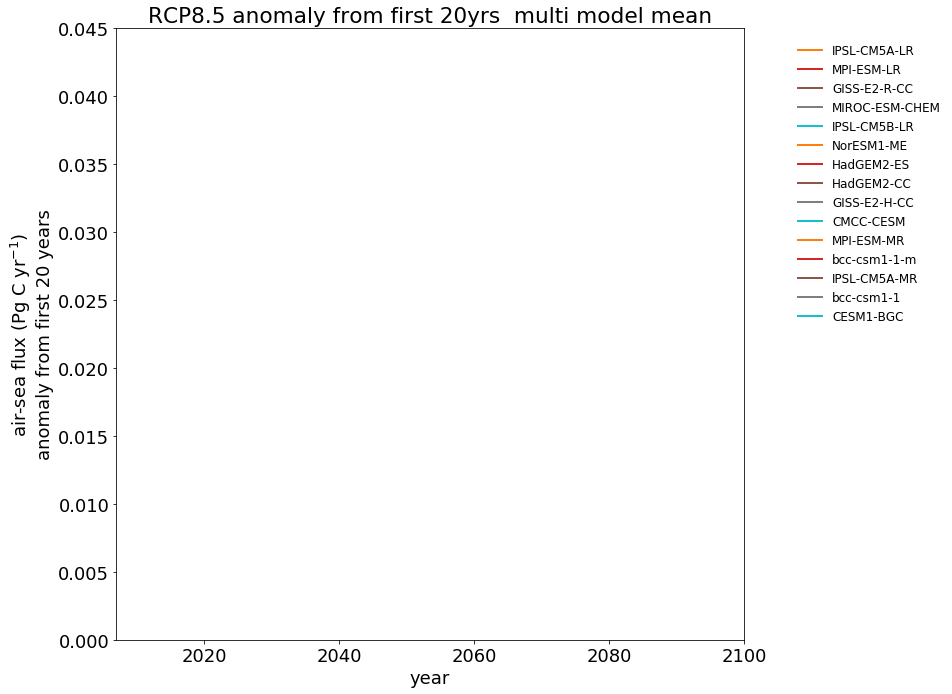

In [187]:
# models = model_names(directory)
# models = list(models)
# models.remove('GFDL-ESM2M')
# models.remove('CNRM-CM5')

# variable = 'fgco2'
# run = 'rcp85'

# font = {'family' : 'normal',
#         'weight' : 'normal',
#         'size'   : 18}

# matplotlib.rc('font', **font)


# initial_value = (np.mean([area_sum(data_dict[run][variable][model]['first20']).data for model in data_dict[run][variable]])*365.0*yearsec)/1.0e12

# plt.figure(figsize=(14,10))
# for model in list(data_dict[run][variable]):
#     df = pd.DataFrame({'tmp':(data_dict[run][variable][model]['timeseries'].data*365.0*yearsec)/1.0e12})
#     plt.plot(data_dict[run][variable][model]['years'],initial_value+df.tmp-df.tmp[0:20].mean(),alpha=0.2,label='_nolegend_')
#     plt.plot(data_dict[run][variable][model]['years'],initial_value+df.tmp.rolling(10).mean()-df.tmp[0:20].mean(),lw=2,label=model)

# plt.xlim([2007,2100])
# plt.ylim([-0.00,0.045])
# plt.legend(loc=8, bbox_to_anchor=(1.2, 0.5),prop={'size': 12},frameon=False)
# plt.xlabel('year')
# plt.ylabel('air-sea flux (Pg C yr$^{-1}$)\nanomaly from first 20 years')
# plt.title('RCP8.5 anomaly from first 20yrs  multi model mean')
# plt.tight_layout()
# plt.savefig('/home/ph290/Documents/figures/class_rcp85_fgco2_ts.png')



In [190]:
# variable = 'fgco2'
# run = 'rcp85'
# models = list(data_dict[run][variable])
# shape = np.shape(data_dict[run][variable][models[0]]['first20'])
# first_period = np.zeros([len(data_dict[run][variable]),shape[0],shape[1]])
# first_period[:] = np.nan
# last_period=first_period.copy()
# for i,model in enumerate(list(data_dict[run][variable])):
#     first_period[i,:,:] = data_dict[run][variable][model]['first20'].data
#     last_period[i,:,:] = data_dict[run][variable][model]['last20'].data


# diff = last_period-first_period

# diff_mean = np.mean(diff,axis=0)

# tmp_cube = data_dict[run][variable][model]['first20']
# tmp_cube.data = diff_mean
# agreement = 0.66
# agreement_map = calculate_agreement(diff,agreement)

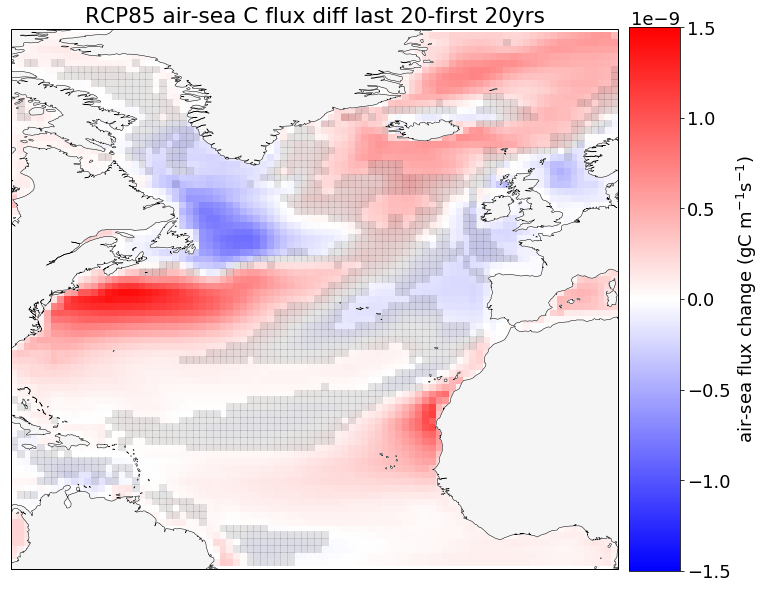

In [191]:
# land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
#                                         edgecolor='face',
#                                         facecolor=cfeature.COLORS['land'])
# coast_50m = cfeature.NaturalEarthFeature('physical', 'coastline', '50m',facecolor='none')

# my_projection = ccrs.PlateCarree()
# my_extent = [-80.0,10,0.0,80.0]

# plt.close('all')
# fig = plt.figure(figsize=(12,10))
# gs = gridspec.GridSpec(10, 11)
# ax1 = plt.subplot(gs[0:10,0:10],projection= my_projection)
# ax2 = plt.subplot(gs[0:10,10:11])



# ax1.set_extent(my_extent, crs=ccrs.PlateCarree())


# lats1 = tmp_cube.coord('latitude').points
# lons1 = tmp_cube.coord('longitude').points
# data1 = tmp_cube.data


# contour_result1 = ax1.pcolormesh(lons1, lats1, data1,vmin=-1.5E-9,vmax=1.5E-9,
# 			transform=ccrs.PlateCarree(),cmap='bwr')
# contour_result2 = ax1.pcolormesh(lons1, lats1, agreement_map,
# 			transform=ccrs.PlateCarree(),cmap='gray',vmin=0,vmax=1,alpha=0.1)

# cbar = fig.colorbar(contour_result1, cax=ax2, orientation='vertical')
# cbar.set_label('air-sea flux change (gC m$^{-1}$s$^{-1}$)')

# ax1.add_feature(land_50m,facecolor='#F5F5F5')
# ax1.add_feature(coast_50m,edgecolor='#000000',lw=0.5)

# ax1.set_title('RCP85 air-sea C flux diff last 20-first 20yrs')

# plt.savefig('/home/ph290/Documents/figures/class_spatial_fgco2_diff.png')

Multi model mean change in update last 20 years - first 20 yeats 
greyed is where fewer than 66% of models agree on the sign of change

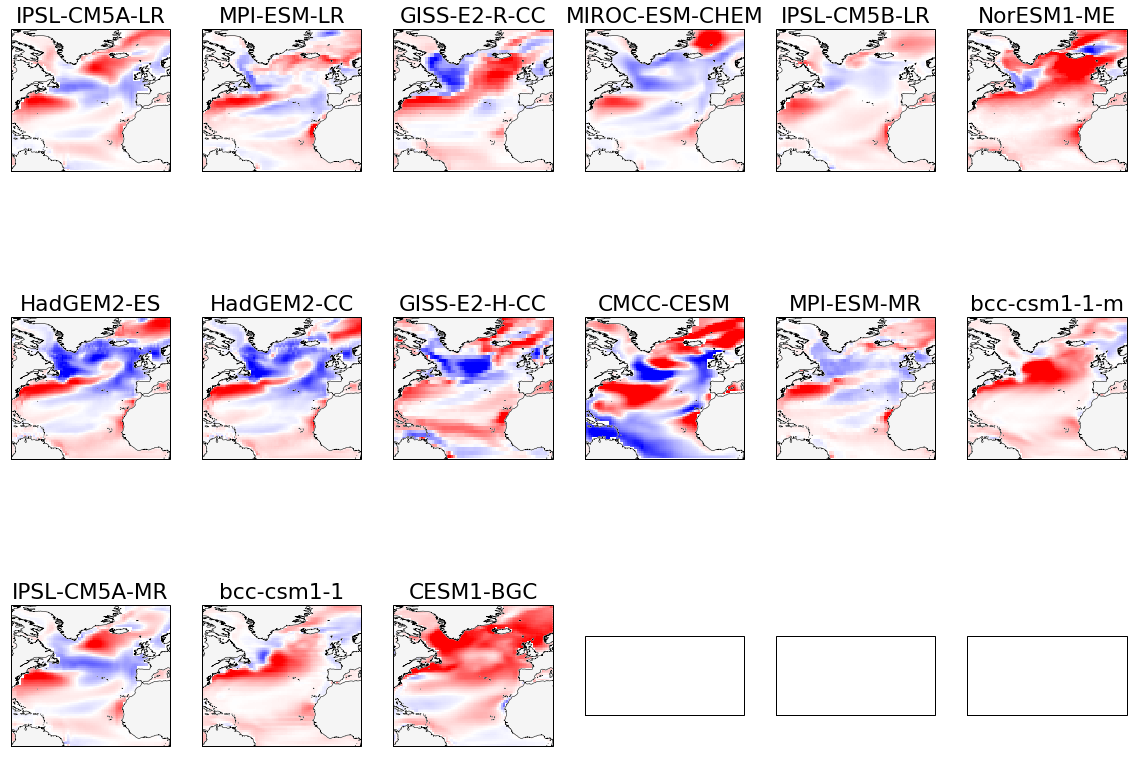

In [192]:
# variable = 'fgco2'
# run = 'rcp85'
# models = list(data_dict[run][variable])

# plt.close('all')
# fig = plt.figure(figsize=(20,15))
# gs = gridspec.GridSpec(3, 6)


 

# axs=[]
# for i in range(3):
#     for j in range(int(np.mean(len(models)/3.0))+1):
#         axs.append(plt.subplot(gs[i:i+1,j:j+1],projection= my_projection))




# for i,model in enumerate(models):
#     tmp_cube = data_dict[run][variable][model]['last20'] - data_dict[run][variable][model]['first20'] 
#     lats1 = tmp_cube.coord('latitude').points
#     lons1 = tmp_cube.coord('longitude').points
#     data1 = tmp_cube.data
#     axs[i].set_extent(my_extent, crs=ccrs.PlateCarree())
#     contour_result1 = axs[i].pcolormesh(lons1, lats1, data1,vmin=-1.5E-9,vmax=1.5E-9,
#         transform=ccrs.PlateCarree(),cmap='bwr')
#     axs[i].add_feature(land_50m,facecolor='#F5F5F5')
#     axs[i].add_feature(coast_50m,edgecolor='#000000',lw=0.5)
#     axs[i].set_title(model)




# # cbar = fig.colorbar(contour_result1, cax=axs[-1])
# # cbar.set_label('Revelle Factor')

# plt.savefig('/home/ph290/Documents/figures/class_spatial_fgco2_by_model.png')

In [201]:
# tmp_cube_talk = mask_where_zero(tmp_cube_talk)
# tmp_cube_dissic = mask_where_zero(tmp_cube_dissic)
# tmp_cube_tos = mask_where_zero(tmp_cube_tos)
# tmp_cube_sos = mask_where_zero(tmp_cube_sos)

# # revelle_factor = carbchem_revelle(10,9.99e9,(tmp_cube_talk *0.0)+15.0,(tmp_cube_talk *0.0)+35.0,tmp_cube_dissic,tmp_cube_talk)
# revelle_factor = carbchem_revelle(10,9.99e9,tmp_cube_tos-273.15,tmp_cube_sos,tmp_cube_dissic,tmp_cube_talk)
# revelle_factor_last = carbchem_revelle(10,9.99e9,tmp_cube_tos_2-273.15,tmp_cube_sos_2,tmp_cube_dissic_2,tmp_cube_talk_2)

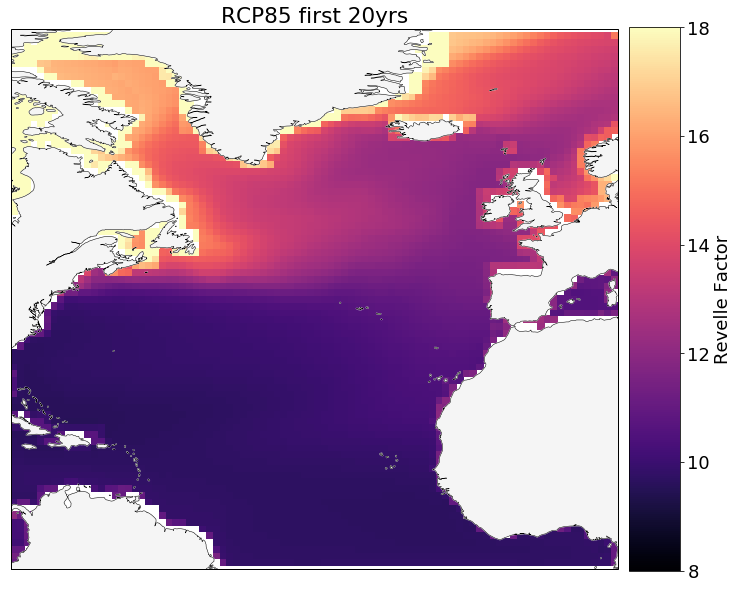

In [202]:


# plt.close('all')
# fig = plt.figure(figsize=(12,10))
# gs = gridspec.GridSpec(10, 11)
# ax1 = plt.subplot(gs[0:10,0:10],projection= my_projection)
# ax2 = plt.subplot(gs[0:10,10:11])



# ax1.set_extent(my_extent, crs=ccrs.PlateCarree())


# lats1 = revelle_factor.coord('latitude').points
# lons1 = revelle_factor.coord('longitude').points
# data1 = revelle_factor.data


# contour_result1 = ax1.pcolormesh(lons1, lats1, data1,vmin=8,vmax=18,
# 			transform=ccrs.PlateCarree(),cmap='magma')


# cbar = fig.colorbar(contour_result1, cax=ax2, orientation='vertical')
# cbar.set_label('Revelle Factor')

# ax1.add_feature(land_50m,facecolor='#F5F5F5')
# ax1.add_feature(coast_50m,edgecolor='#000000',lw=0.5)

# ax1.set_title('RCP85 first 20yrs')

# plt.savefig('/home/ph290/Documents/figures/class_spatial_revelle_diff.png')

Revelle each model

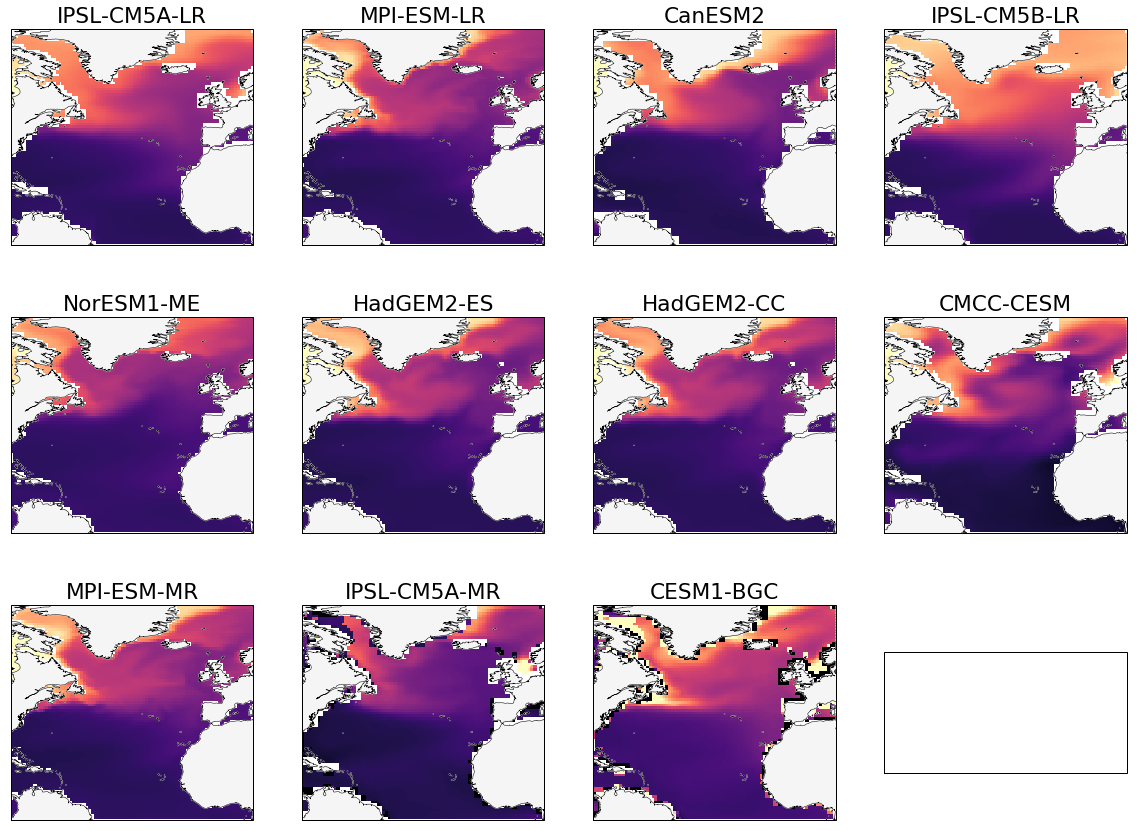

In [204]:
# variable = 'talk'
# run = 'rcp85'
# models = list(data_dict[run][variable])
# models.remove('BNU-ESM')

# plt.close('all')
# fig = plt.figure(figsize=(20,15))
# gs = gridspec.GridSpec(3, 4)




 

# axs=[]
# for i in range(3):
#     for j in range(int(np.mean(len(models)/3.0))+1):
#         axs.append(plt.subplot(gs[i:i+1,j:j+1],projection= my_projection))




# for i,model in enumerate(models):
#     revelle_factor = carbchem_revelle(10,9.99e9,data_dict[run]['tos'][model]['first20']-273.15,data_dict[run]['sos'][model]['first20'],data_dict[run]['dissic'][model]['first20'],data_dict[run]['talk'][model]['first20'])
#     lats1 = revelle_factor.coord('latitude').points
#     lons1 = revelle_factor.coord('longitude').points
#     data1 = revelle_factor.data
#     axs[i].set_extent(my_extent, crs=ccrs.PlateCarree())
#     contour_result1 = axs[i].pcolormesh(lons1, lats1, data1,vmin=8,vmax=18,
#         transform=ccrs.PlateCarree(),cmap='magma')
#     axs[i].add_feature(land_50m,facecolor='#F5F5F5')
#     axs[i].add_feature(coast_50m,edgecolor='#000000',lw=0.5)
#     axs[i].set_title(model)




# # cbar = fig.colorbar(contour_result1, cax=axs[-1])
# # cbar.set_label('Revelle Factor')

# plt.savefig('/home/ph290/Documents/figures/class_spatial_revelle_by_model.png')


Subtropical relationship between revelle and change in CO2 flux

Not Just N. Atl


IPSL-CM5A-LR
MPI-ESM-LR
IPSL-CM5B-LR
NorESM1-ME
HadGEM2-ES
HadGEM2-CC
MPI-ESM-MR
IPSL-CM5A-MR


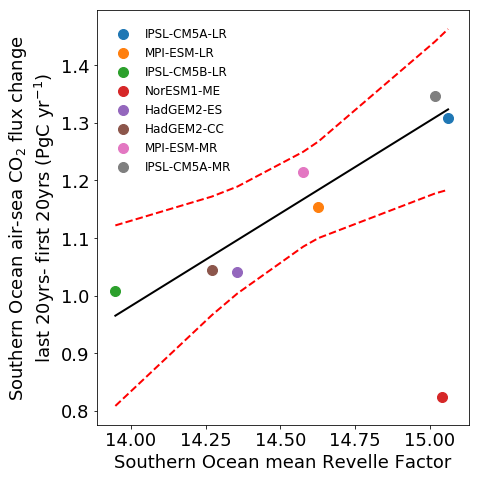

In [221]:
from statsmodels.stats.outliers_influence import summary_table
import statsmodels.api as sm
variable = 'talk'
run = 'rcp85'
models = list(data_dict[run][variable])
models.remove('CanESM2')
models.remove('BNU-ESM')
models.remove('CMCC-CESM')
models.remove('CESM1-BGC')#  Note that CESM1-BGC has a salinity which *appears to be* a factor of 1000 too small. 

plt.close('all')
fig = plt.figure(figsize=(7,7))
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0:1,0:1])

#'atl_n_subtropics','subtropics','atl_s_subtropics','pac_n_subtropicsE','pac_n_subtropicsW','pac_s_subtropicsE','pac_s_subtropicsW','global','atl_n_subpolar','pac_n_subpolarE','pac_n_subpolarW','S_ocean','arctic'
regions = ['atl_n_subtropics','global','S_ocean','N_alt']
region = 'S_ocean'
run='rcp85'
x=[]
y=[]
for i,model in enumerate(models):
    print model
    sal_tmp = data_dict_region[region][run]['sos'][model]['first20'].copy()
    revelle_factor = carbchem_revelle(10,9.99e9,data_dict_region[region][run]['tos'][model]['first20']-273.15,sal_tmp,data_dict_region[region][run]['dissic'][model]['first20'],data_dict_region[region][run]['talk'][model]['first20'])
    rf_aa = area_avg(revelle_factor)
    first_tmp = data_dict_region[region][run]['fgco2'][model]['first20'].copy()
    last_tmp =  data_dict_region[region][run]['fgco2'][model]['last20'].copy()
    fgco2_change = area_sum(last_tmp - first_tmp)
#     if model <> 'NorESM1-ME':
    ax1.scatter(rf_aa.data,((fgco2_change.data*yearsec)/1.0e12),s=100,label = model)
    if model <> 'NorESM1-ME':
        x.append(rf_aa.data)
        y.append((fgco2_change.data*yearsec)/1.0e12)
    
xsort = np.argsort(x)
x = np.array(x)
y = np.array(y)
x = x[xsort]
y = y[xsort]
xb = sm.add_constant(x)
model = sm.OLS(y,xb)
results = model.fit()
x2 = np.linspace(np.min(x),np.max(x),np.size(x))
y2 = results.predict(sm.add_constant(x2))
from statsmodels.stats.outliers_influence import summary_table
st, data, ss2 = summary_table(results, alpha=0.005)
fittedvalues = data[:,2]
predict_mean_se = data[:,3]
predict_mean_ci_low, predict_mean_ci_upp = data[:,4:6].T
predict_ci_low, predict_ci_upp = data[:,6:8].T
# plt.scatter(x,y)
plt.plot(x, fittedvalues, 'k', lw=2)
# plt.plot(x, predict_ci_low, 'r--', lw=2)
# plt.plot(x, predict_ci_upp, 'r--', lw=2)
plt.plot(x, predict_mean_ci_low, 'r--', lw=2)
plt.plot(x, predict_mean_ci_upp, 'r--', lw=2)
    
# plt.ylim(0.03,0.06)
# plt.xlim(11.0,11.7)2
# cbar = fig.colorbar(contour_result1, cax=axs[-1])
# cbar.set_label('Revelle Factor')
# plt.legend(loc=8, bbox_to_anchor=(1.2, 0.5),prop={'size': 12},frameon=False)
plt.legend(loc=8, bbox_to_anchor=(0.2, 0.58),prop={'size': 12},frameon=False)
ax1.set_xlabel('Southern Ocean mean Revelle Factor')
ax1.set_ylabel('Southern Ocean air-sea CO$_2$ flux change\nlast 20yrs- first 20yrs (PgC yr$^{-1}$)')
# plt.xlim([13.5,15.5])
# plt.ylim([0.035,0.06])
# plt.title('Southern Ocean')
plt.tight_layout()
plt.savefig('/home/ph290/Documents/figures/class_scatter_revelle_v_fgco2_s_ocean.png')

2.5592406491625144


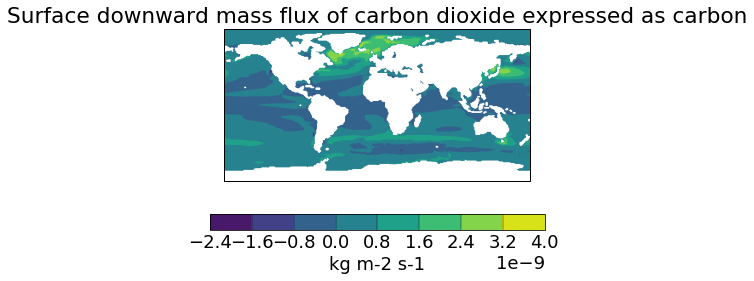

In [209]:
# model = 'HadGEM2-ES'

# # print data_dict_region[region][run]['fgco2'][model]['first20']
# region = 'global'
# run='rcp85'
# first_tmp = data_dict_region[region][run]['fgco2'][model]['first20'].copy()
# last_tmp =  data_dict_region[region][run]['fgco2'][model]['last20'].copy()
# first_aa = area_sum(first_tmp)
# fgco2_change = area_sum(first_tmp - last_tmp)
# yearsec = 60.0*60.0*24.0*365
# print ((first_aa.data*yearsec)/1.0e12)
# qplt.contourf(first_tmp)
# # data_dict_region[region][run]['sos'][model]['first20']

Global air-sea flux

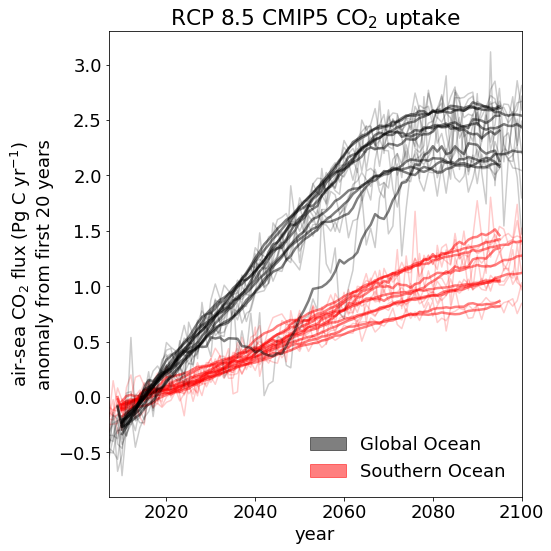

In [213]:
# # models = model_names(directory)
# # models = list(models)
# # models.remove('GFDL-ESM2M')
# # models.remove('CNRM-CM5')
# models = list(data_dict['rcp85']['fgco2'])
# models_to_remove = ['MIROC-ESM-CHEM','GISS-E2-R-CC','GISS-E2-H-CC','bcc-csm1-1-m','bcc-csm1-1']
# for m in models_to_remove:
#     models.remove(m)
# # models.remove('CanESM2')
# # models.remove('BNU-ESM')
# # models.remove('CMCC-CESM')
# variable = 'fgco2'
# run = 'rcp85'



# font = {'family' : 'normal',
#         'weight' : 'normal',
#         'size'   : 18}

# matplotlib.rc('font', **font)

# regions = ['atl_n_subtropics','global','S_ocean','N_alt']
# region = regions[2]

# # initial_value = (np.mean([area_sum(data_dict[run][variable][model]['first20']).data for model in models])*365.0*yearsec)/1.0e12
# plt.figure(figsize=(8,8))
# for model in models: 
#         df = pd.DataFrame({'tmp':((data_dict_region[region][run][variable][model]['timeseries'].data*yearsec)/1.0e12)})
#         plt.plot(data_dict_region[region][run][variable][model]['years'],df.tmp-df.tmp[0:20].mean(),label='_nolegend_',color='r',alpha=0.2)
#         plt.plot(data_dict_region[region][run][variable][model]['years']-5,df.tmp.rolling(10).mean()-df.tmp[0:20].mean(),lw=2.5,label=model,alpha=0.5,color='r')

        
# region = regions[1]

# # initial_value = (np.mean([area_sum(data_dict[run][variable][model]['first20']).data for model in models])*365.0*yearsec)/1.0e12
# # initial_value = np.mean(data_dict_region[region][run][variable][model]['timeseries'][0:20].data*365.0*yearsec/1.0e12)
# for model in models: 
#         df = pd.DataFrame({'tmp':((data_dict_region[region][run][variable][model]['timeseries'].data*yearsec)/1.0e12)})
#         plt.plot(data_dict_region[region][run][variable][model]['years'],df.tmp-df.tmp[0:20].mean(),label='_nolegend_',color='k',alpha=0.2)
#         plt.plot(data_dict_region[region][run][variable][model]['years']-5,df.tmp.rolling(10).mean()-df.tmp[0:20].mean(),lw=2.5,label=model,alpha=0.5,color='k')


# import matplotlib.patches as mpatches

# red_patch = mpatches.Patch(color='red', label='Southern Ocean',alpha=0.5)
# black_patch = mpatches.Patch(color='k', label='Global Ocean',alpha=0.5)
# plt.legend(loc=4,handles=[black_patch,red_patch],prop={'size': 18},frameon=False)


        
# plt.xlim([2007,2100])
# # plt.ylim([0.00,0.09])
# # plt.legend(loc=8, bbox_to_anchor=(1.2, 0.5),prop={'size': 12},frameon=False)
# # plt.legend(loc=0,prop={'size': 12},frameon=False)
# plt.xlabel('year')
# plt.ylabel('air-sea CO$_2$ flux (Pg C yr$^{-1}$)\nanomaly from first 20 years')
# plt.title('RCP 8.5 CMIP5 CO$_2$ uptake')
# plt.tight_layout()
# plt.savefig('/home/ph290/Documents/figures/global_rcp85_fgco2_ts.png')

/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1357: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'model timestep number'.
  warnings.warn(msg.format(self.name()))


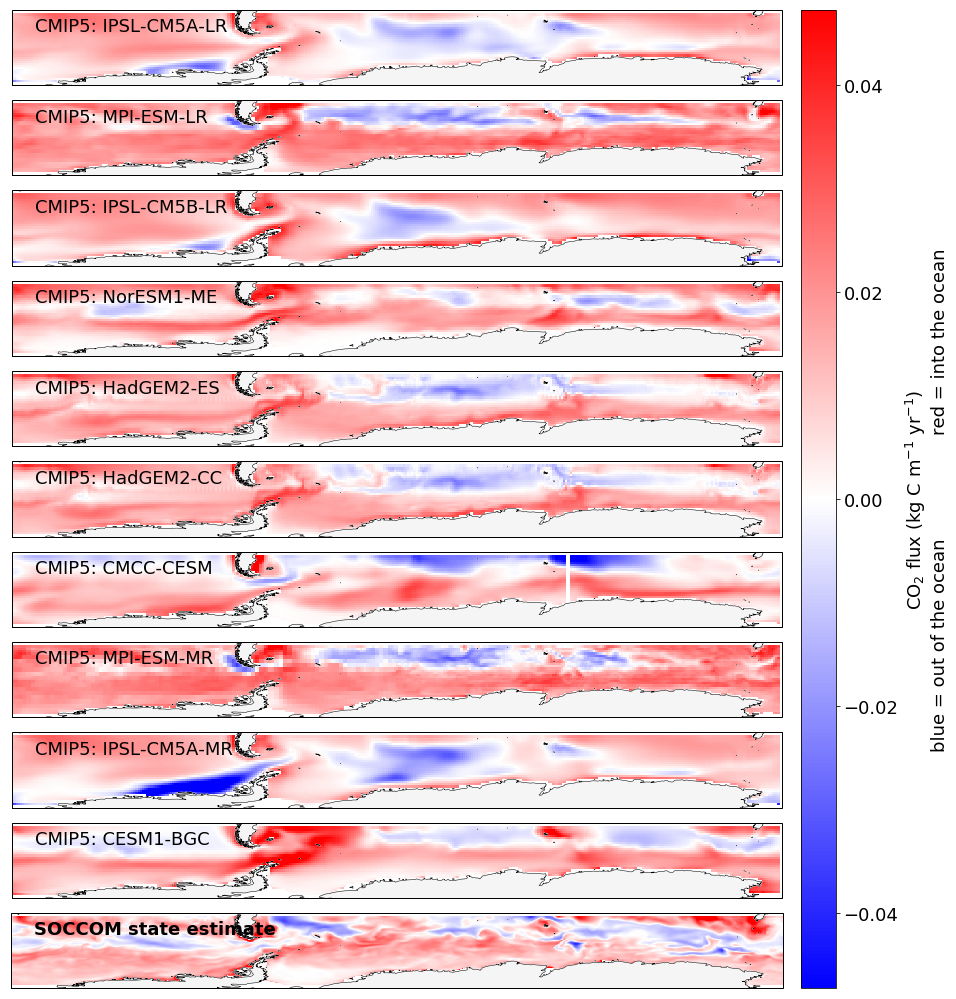

In [216]:

# plt.close('all')
# fig = plt.figure(figsize=(15,18))
# # gs = gridspec.GridSpec(3, 6)
# gs = gridspec.GridSpec(11, 20)
# yearsec = 60.0*60.0*24*365
 
# regions = ['atl_n_subtropics','global','S_ocean','N_alt']
# region = regions[2]
    
# axs=[]
# # for i in range(3):
# #     for j in range(int(np.mean(len(models)/3.0))+1):
# #         axs.append(plt.subplot(gs[i:i+1,j:j+1],projection= my_projection))
# for i in range(len(models)+1):
#     axs.append(plt.subplot(gs[i,0:19],projection= my_projection))

# axs.append(plt.subplot(gs[0:11,19:20]))

# for i,model in enumerate(models):
#     tmp_cube = data_dict_region[region][run][variable][model]['first20']
#     tmp_cube = extract_region(tmp_cube,-180,180,-77,-45)
#     lats1 = tmp_cube.coord('latitude').points
#     lons1 = tmp_cube.coord('longitude').points
#     data1 = tmp_cube.data*yearsec
# #     axs[i].set_extent(my_extent, crs=ccrs.PlateCarree())
#     contour_result1 = axs[i].pcolormesh(lons1, lats1, data1,vmin=-1.5E-9*yearsec,vmax=1.5E-9*yearsec,
#         transform=ccrs.PlateCarree(),cmap='bwr')
#     axs[i].add_feature(land_50m,facecolor='#F5F5F5')
#     axs[i].add_feature(coast_50m,edgecolor='#000000',lw=0.5)
# #     axs[i].set_title(model)
#     axs[i].text(0.03,0.9,'CMIP5: '+model,
#         horizontalalignment="left",
#         verticalalignment="top",transform=axs[i].transAxes)

# i+=1
# c = iris.load_cube('/home/ph290/Downloads/bsose_i105_2008to2012_monthly_surfCO2flx.nc')
# c = extract_region(c,-180,180,-77,-45)
# tmp_cube=c.collapsed('time',iris.analysis.MEAN)
# lats1 = tmp_cube.coord('latitude').points
# lons1 = tmp_cube.coord('longitude').points
# data1 = (tmp_cube.data*yearsec)/(44.0)
# contour_result1 = axs[i].pcolormesh(lons1, lats1, data1,vmin=-1.5E-9*yearsec,vmax=1.5E-9*yearsec,
#     transform=ccrs.PlateCarree(),cmap='bwr')
# axs[i].add_feature(land_50m,facecolor='#F5F5F5')
# axs[i].add_feature(coast_50m,edgecolor='#000000',lw=0.5)
# axs[i].text(0.03,0.9,'SOCCOM state estimate',
#     horizontalalignment="left",
#     verticalalignment="top",transform=axs[i].transAxes, weight = 'bold')


# # i+=1
# # c = iris.load_cube('/home/ph290/Downloads/spco2_MPI_SOM-FFN_v2018_clim.nc','CO2 flux density climatology')
# # c = extract_region(c,-180,180,-77,-45)
# # tmp_cube=c[0].copy()
# # tmp_cube.data = np.mean(c.data,axis=0)
# # tmp_cube.data = np.ma.masked_where(tmp_cube.data > 1.0,tmp_cube.data)
# # lats1 = tmp_cube.coord('latitude').points
# # lons1 = tmp_cube.coord('longitude').points
# # data1 = tmp_cube.data/44.0
# # contour_result1 = axs[i].pcolormesh(lons1, lats1, data1,vmin=-1.5E-9*yearsec,vmax=1.5E-9*yearsec,
# #     transform=ccrs.PlateCarree(),cmap='bwr')
# # axs[i].add_feature(land_50m,facecolor='#F5F5F5')
# # axs[i].add_feature(coast_50m,edgecolor='#000000',lw=0.5)
# # axs[i].text(0.03,0.9,'Landschutzer observation-based climatology',
# #     horizontalalignment="left",
# #     verticalalignment="top",transform=axs[i].transAxes)



# cbar = fig.colorbar(contour_result1, cax=axs[-1])
# cbar.set_label('CO$_2$ flux (kg C m$^{-1}$ yr$^{-1}$)\nblue = out of the ocean                  red = into the ocean')

# plt.savefig('/home/ph290/Documents/figures/class_spatial_fgco2_by_model_s_ocean.png')

data missing
data missing
data missing
data missing


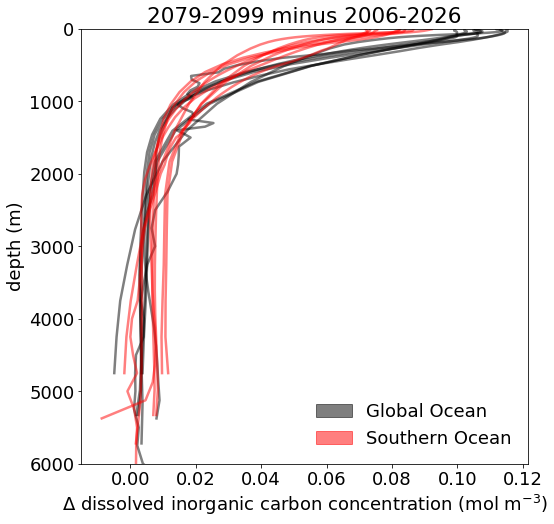

In [218]:
# plt.close('all')
# fig = plt.figure(figsize=(8,8))
# # gs = gridspec.GridSpec(3, 6)


# font = {'family' : 'normal',
#         'weight' : 'normal',
#         'size'   : 18}

# matplotlib.rc('font', **font)

# variable = 'dissic'
# regions = ['atl_n_subtropics','global','S_ocean','N_alt']
# region = regions[1]
# run='rcp85'    
# for i,model in enumerate(models):
#     try:
#         a = data_dict_region_profiles[region][run][variable][model]['first20_profile']
#         b = data_dict_region_profiles[region][run][variable][model]['last20_profile']
#         plt.plot(b-a,data_dict_region_profiles[region][run][variable][model]['depths'],lw=2.5,alpha=0.5,color='k')
#     except:
#         print 'data missing'

        
# region = regions[2]
    
# for i,model in enumerate(models):
#     try:
#         a = data_dict_region_profiles[region][run][variable][model]['first20_profile']
#         b = data_dict_region_profiles[region][run][variable][model]['last20_profile']
#         plt.plot(b-a,data_dict_region_profiles[region][run][variable][model]['depths'],lw=2.5,alpha=0.5,color='r')
#     except:
#         print 'data missing'
        
        
# # plt.legend(loc=8, bbox_to_anchor=(0.75, 0.5),prop={'size': 12},frameon=False)
# import matplotlib.patches as mpatches

# red_patch = mpatches.Patch(color='red', label='Southern Ocean',alpha=0.5)
# black_patch = mpatches.Patch(color='k', label='Global Ocean',alpha=0.5)
# plt.legend(loc=4,handles=[black_patch,red_patch],prop={'size': 18},frameon=False)

# plt.ylim([6000,0])
# plt.xlabel('$\Delta$ dissolved inorganic carbon concentration (mol m$^{-3}$)')
# plt.ylabel('depth (m)')
# plt.title('2079-2099 minus 2015,2035')
# plt.savefig('/home/ph290/Documents/figures/class_spatial_dic_by_model_s_ocean_profile.png')

subpolar relationship between revelle and change in CO2 flux

In [ ]:
glodap_dic_file ='/data/NAS-ph290/ph290/observations/GLODAPv2_Mapped_Climatologies/GLODAPv2.2016b_MappedClimatologies/GLODAPv2.2016b.TCO2.nc'
glodap_talk_file ='/data/NAS-ph290/ph290/observations/GLODAPv2_Mapped_Climatologies/GLODAPv2.2016b_MappedClimatologies/GLODAPv2.2016b.TAlk.nc'
glodap_dic = iris.load_cube(glodap_dic_file,'moles of dissolved inorganic carbon per unit mass in seawater')[0]/1026.0
glodap_talk = iris.load_cube(glodap_talk_file,'seawater alkalinity expressed as mole equivalent per unit mass')[0]/1026.0

lon_west,lon_east,lat_south,lat_north=-80.0,10,0.0,80.0
glodap_dic_n_atl = area_avg2(glodap_dic,lon_west,lon_east,lat_south,lat_north).data
glodap_talk_n_atl = area_avg2(glodap_talk,lon_west,lon_east,lat_south,lat_north).data

lon_west,lon_east,lat_south,lat_north=-80.0,10,-45,0
glodap_dic_s_atl = area_avg2(glodap_dic,lon_west,lon_east,lat_south,lat_north).data
glodap_talk_s_atl = area_avg2(glodap_talk,lon_west,lon_east,lat_south,lat_north).data

lon_west,lon_east,lat_south,lat_north=-180.0,180.0,-90.0,-45.0
glodap_dic_so = area_avg2(glodap_dic,lon_west,lon_east,lat_south,lat_north).data
glodap_talk_so = area_avg2(glodap_talk,lon_west,lon_east,lat_south,lat_north).data

lon_west,lon_east,lat_south,lat_north=130,360-100,0,60
glodap_dic_np = area_avg2(glodap_dic,lon_west,lon_east,lat_south,lat_north).data
glodap_talk_np = area_avg2(glodap_talk,lon_west,lon_east,lat_south,lat_north).data

lon_west,lon_east,lat_south,lat_north=130,360-100,-45,0
glodap_dic_sp = area_avg2(glodap_dic,lon_west,lon_east,lat_south,lat_north).data
glodap_talk_sp = area_avg2(glodap_talk,lon_west,lon_east,lat_south,lat_north).data

lon_west,lon_east,lat_south,lat_north=42,100,-45,20
glodap_dic_io = area_avg2(glodap_dic,lon_west,lon_east,lat_south,lat_north).data
glodap_talk_io = area_avg2(glodap_talk,lon_west,lon_east,lat_south,lat_north).data


In [ ]:
blue lines = revelle factor calculated at 5 degrees, colors and black lines at 20 degrees

In [ ]:
# t=(data_dict[run]['tos'][model]['first20']*0.0)+15
s=(data_dict[run]['sos'][model]['first20']*0.0)+35.0
talk=data_dict[run]['dissic'][model]['first20']
dissic=data_dict[run]['talk'][model]['first20']
t.data[:]=20.0
s.data[:]=35.0
shape = np.shape(talk)
a=np.linspace(2.1,2.5,shape[0])
a2=np.tile(a,(shape[1],1))
a2 = np.flipud(np.rot90(a2))
d=np.linspace(1.8,2.2,shape[1])
d2=np.tile(d,(shape[0],1))
talk.data = a2
dissic.data = d2
# d=np.linspace(1.5,3.0,shape[1])
# aa, dd = np.meshgrid(a,d, sparse=True)
revelle_factor = carbchem_revelle(10,9.99e9,t,s,talk,dissic)

fig = plt.figure(figsize=(12,9))
cb1 = plt.contourf(d,a,revelle_factor.data,np.linspace(0,18,55),cmap='Reds')
cb1b = plt.contour(d,a,revelle_factor.data,10,linewidths=1,colors='k')
plt.clabel(cb1b, inline=1, fontsize=12)

t.data[:]=5.0
s.data[:]=35.0
revelle_factor = carbchem_revelle(10,9.99e9,t,s,talk,dissic)
cb2 = plt.contour(d,a,revelle_factor.data,10,linewidths=1,colors='b')
plt.clabel(cb2, inline=1, fontsize=12)


plt.xlabel('Dissolved Organic Carbon (mmol m$^{-3}$)')
plt.ylabel('Alkalinity (mmol equivalent m$^{-3}$)')


# plt.colorbar(cb1)
# plt.colorbar(cb2)



plt.scatter(glodap_dic_n_atl,glodap_talk_n_atl,label='N. Atl.',s=200)
plt.scatter(glodap_dic_s_atl,glodap_talk_s_atl,label='S. Atl.',s=200)
plt.scatter(glodap_dic_np,glodap_talk_np,label='N. Pacific',s=200)
plt.scatter(glodap_dic_sp,glodap_talk_sp,label='S. Pacific',s=200)
plt.scatter(glodap_dic_so,glodap_talk_so,label='S. Ocean',s=200)
plt.scatter(glodap_dic_io,glodap_talk_io,label='Indian',s=200)


plt.legend(loc=8, bbox_to_anchor=(1.1, 0.5),prop={'size': 15},frameon=False)



plt.tight_layout()
plt.savefig('/home/ph290/Documents/figures/class_revelle_explained.png')
